In [ ]:
#!pip uninstall tensorflow
#!pip install tensorflow

import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model

print(tf.__version__)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
%rm -rf ./MNIST/logs/
log_dir = "MNIST/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Load in the data
mnist = tf.keras.datasets.mnist

def normalize_set(dataset):
  arr=[]
  for image in dataset:
      arr.append((image - np.min(image)) / (np.max(image) - np.min(image)))
  return np.array(arr)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = normalize_set(x_train)
x_test = normalize_set(x_test)

print("x_train.shape: ", x_train.shape)
#plt.imshow(x_train[0], cmap='gray')
print("y_train.shape: ", y_train.shape)

# the data is only 2D!
# convolution expects height * width * color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

# number of classes
# the function set returns a vector with only the unique values
K = len(set(y_train))
print("number of classes:", K)

#The target classes are a signle numerical values of the class label.
#We need to make them float tensor in order to manipulate them.
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)
print("y_train : ", y_train)

2.9.2
x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
(60000, 28, 28, 1)
number of classes: 10
y_train :  tf.Tensor([5 0 4 ... 5 6 8], shape=(60000,), dtype=int32)


In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[], 'accuracy':[],'val_accuracy':[], 'loss_avg':[],'val_loss_avg':[], 'accuracy_avg':[],'val_accuracy_avg':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        #self.history['val_loss'].append(logs.get('val_loss'))        
        #self.history['val_accuracy'].append(logs.get('val_accuracy'))
        '''On batch end is returned None'''

    def on_epoch_end(self, epoch, logs={}):
        self.history['loss_avg'].append(logs.get('loss'))
        self.history['val_loss_avg'].append(logs.get('val_loss'))
        self.history['accuracy_avg'].append(logs.get('accuracy'))
        self.history['val_accuracy_avg'].append(logs.get('val_accuracy'))

    def on_test_begin(self, logs={}):
        self.test_hist = {'loss':[], 'accuracy':[]}
    def on_test_batch_end(self, batch, logs={}):
        self.test_hist['loss'].append(logs.get('loss'))
        self.test_hist['accuracy'].append(logs.get('accuracy'))

In [ ]:

#A custom loss function can be created by defining a function that takes the true values and predicted values as required parameters. 
#The function should return an array of losses. The function can then be passed at the compile stage. 
def MSE_onehot(label, pred):
    y=tf.one_hot(label, 10, axis=1) 
    error = tf.subtract(y[:,:,0],pred) #Evaluation error
    #print("label shape: ", label.shape )  
    #print("one hot label shape: ", y.shape ) 
    #print("Error shape: ", error.shape)
    error=tf.pow(error,2)
    error=tf.divide(error,K)
    loss = tf.math.reduce_sum(error,axis=1)
    return loss 


model = tf.keras.models.Sequential()

model.add(Input(shape=x_train[0].shape))
model.add(Conv2D(8, (3, 3), strides=1, activation='relu', padding="same" ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(2, (3, 3), strides=1, activation='relu', padding="same" ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(98, activation='sigmoid'))
model.add(Dense(K, activation='sigmoid'))

model.summary()

# Compile and fit
# Note: make sure you are using the GPU for this!
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

opt   = tf.keras.optimizers.experimental.SGD( learning_rate=0.5 )
history = LossHistory()

model.compile(optimizer=opt, loss=MSE_onehot, metrics=['accuracy'])

r = model.fit(x_train, y_train, validation_split = 0.16667, epochs=1, batch_size=1,  callbacks=[history, tensorboard_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 2)         146       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 2)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 98)                0         
                                                                 
 dense_6 (Dense)             (None, 98)               

49999/49999 [==============================] - 137s 3ms/step - loss: 0.0171 - accuracy: 0.8915 - val_loss: 0.0078 - val_accuracy: 0.9568


In [ ]:
model.evaluate(x_test, y_test, batch_size=1, callbacks=[history])

10000/10000 [==============================] - 17s 2ms/step - loss: 0.0077 - accuracy: 0.9551


[0.007747701834887266, 0.9550999999046326]

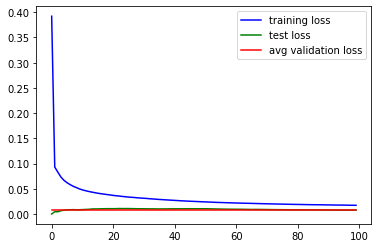

In [ ]:
# Plot loss per iteration
loss=history.history['loss'][::500]
test_loss=history.test_hist['loss'][::100]
avg_val_loss=np.tile(history.history['val_loss_avg'],100)

plt.plot(loss,label='training loss',color='blue' )
plt.plot(test_loss, label='test loss', color='green')
plt.plot(avg_val_loss, label='avg validation loss', color='red')
plt.plot()
plt.legend()


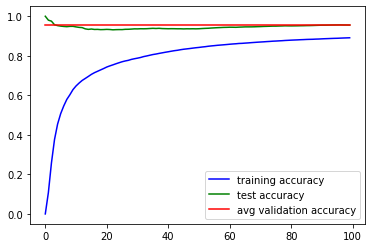

In [ ]:
# Plot accuracy per iteration
acc=history.history['accuracy'][::500]
avg_val_acc=np.tile(history.history['val_accuracy_avg'],100)
test_acc=history.test_hist['accuracy'][::100]

plt.plot(acc, label='training accuracy', color='blue')
plt.plot(test_acc, label='test accuracy', color='green')
plt.plot(avg_val_acc, label='avg validation accuracy', color='red')
plt.legend()

In [ ]:
#Execute tensorboard
#%tensorboard --logdir MNIST/logs/fit

313/313 [==============================] - 2s 7ms/step
Confusion matrix, without normalization
[[ 963    1    1    0    0    0    9    2    3    1]
 [   0 1118    6    2    1    0    2    0    6    0]
 [   9    5  964   19    5    0    3   11   15    1]
 [   1    0    7  978    1    4    0    7   10    2]
 [   0    1    3    0  958    0    6    1    2   11]
 [   5    0    1   14    2  849    8    1    6    6]
 [   9    1    0    0    4    6  935    0    3    0]
 [   6    5   11    5    7    0    0  979    3   12]
 [  10    1    5   33    6   13    7    6  886    7]
 [   9    7    1   14   28   10    0   12    7  921]]


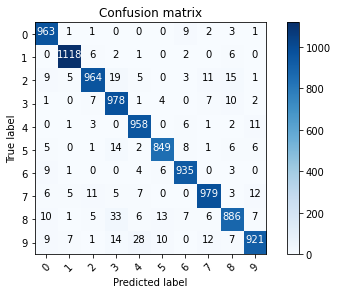

In [ ]:
# Plot confusion matrix

#Ci dice per un label quante predizioni ha ricevuto quel label
#sulla diagonale abbiamo i valori del targhet = predizione 
#avremo anche valori non sulla diagonale che avvengono quando si sbaglia

#Dai risultati si vede che spesso ha sbagliato confondendo 9 con 4, 7 con 1 e 2
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

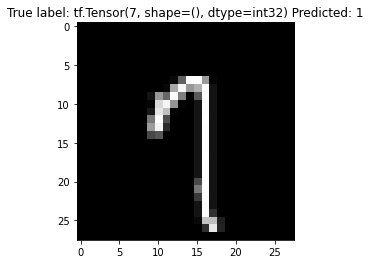

In [ ]:
# Show some misclassified examples

#We can do this using the np.where function, simply returns the index value with
#an input array is true.
#So we can pass in the boolean array p_test not equal to y_test.
#Note that the where function returns two things but we only care about the first thing which is the actual indices.

misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)

#cmap = gray altrimenti la interpreta diversamente 
plt.imshow(x_test[i][:,:,0], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));